In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:


!mkdir /kaggle/working/Grape
!mkdir /kaggle/working/Grape/test
!mkdir /kaggle/working/Grape/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Grape* /kaggle/working/Grape/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Grape* /kaggle/working/Grape/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(156),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Grape/train'
test_path='/kaggle/working/Grape/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 10000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*78*78, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# iter = 0
# for epoch in range(int(num_epochs)):
#     for i, (images, labels) in enumerate(train_loader):
#         images = Variable(images.cuda())
#         labels = Variable(labels.cuda())
        
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         iter += 1
        
#         if iter % 500 == 0:
#             correct = 0
#             total = 0
#             for images, labels in test_loader:
#                 images = Variable(images.cuda())
#                 outputs = model(images)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
                
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()
                
#             accuracy = 100 * correct / total
#             print('Iteration: {}. Loss {}. Accuracy: {}'.format(iter, loss.data, accuracy))

In [4]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [5]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [6]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 407/407 [00:39<00:00, 10.33it/s]


Train Loss: 1.267 | Accuracy: 42.741


100%|██████████| 102/102 [00:08<00:00, 12.52it/s]


Test Loss: 0.989 | Accuracy: 57.583

Epoch : 2


100%|██████████| 407/407 [00:33<00:00, 12.30it/s]


Train Loss: 0.965 | Accuracy: 57.498


100%|██████████| 102/102 [00:08<00:00, 12.26it/s]


Test Loss: 0.853 | Accuracy: 59.433

Epoch : 3


100%|██████████| 407/407 [00:32<00:00, 12.41it/s]


Train Loss: 0.783 | Accuracy: 65.703


100%|██████████| 102/102 [00:07<00:00, 13.16it/s]


Test Loss: 0.746 | Accuracy: 65.906

Epoch : 4


100%|██████████| 407/407 [00:32<00:00, 12.71it/s]


Train Loss: 0.712 | Accuracy: 69.425


100%|██████████| 102/102 [00:09<00:00, 11.30it/s]


Test Loss: 0.911 | Accuracy: 59.556

Epoch : 5


100%|██████████| 407/407 [00:32<00:00, 12.53it/s]


Train Loss: 0.671 | Accuracy: 70.994


100%|██████████| 102/102 [00:08<00:00, 11.62it/s]


Test Loss: 0.855 | Accuracy: 58.323

Epoch : 6


100%|██████████| 407/407 [00:32<00:00, 12.40it/s]


Train Loss: 0.654 | Accuracy: 72.685


100%|██████████| 102/102 [00:08<00:00, 12.71it/s]


Test Loss: 0.673 | Accuracy: 70.931

Epoch : 7


100%|██████████| 407/407 [00:32<00:00, 12.51it/s]


Train Loss: 0.628 | Accuracy: 73.854


100%|██████████| 102/102 [00:07<00:00, 13.34it/s]


Test Loss: 1.327 | Accuracy: 59.433

Epoch : 8


100%|██████████| 407/407 [00:33<00:00, 12.28it/s]


Train Loss: 0.614 | Accuracy: 74.831


100%|██████████| 102/102 [00:08<00:00, 11.67it/s]


Test Loss: 0.711 | Accuracy: 68.711

Epoch : 9


100%|██████████| 407/407 [00:32<00:00, 12.66it/s]


Train Loss: 0.592 | Accuracy: 75.815


100%|██████████| 102/102 [00:09<00:00, 10.94it/s]


Test Loss: 0.552 | Accuracy: 77.374

Epoch : 10


100%|██████████| 407/407 [00:32<00:00, 12.43it/s]


Train Loss: 0.580 | Accuracy: 76.430


100%|██████████| 102/102 [00:08<00:00, 12.09it/s]


Test Loss: 0.561 | Accuracy: 78.083

Epoch : 11


100%|██████████| 407/407 [00:31<00:00, 12.78it/s]


Train Loss: 0.556 | Accuracy: 77.553


100%|██████████| 102/102 [00:08<00:00, 12.06it/s]


Test Loss: 0.579 | Accuracy: 76.387

Epoch : 12


100%|██████████| 407/407 [00:32<00:00, 12.45it/s]


Train Loss: 0.547 | Accuracy: 78.130


100%|██████████| 102/102 [00:08<00:00, 12.56it/s]


Test Loss: 0.598 | Accuracy: 74.969

Epoch : 13


100%|██████████| 407/407 [00:33<00:00, 12.21it/s]


Train Loss: 0.533 | Accuracy: 78.776


100%|██████████| 102/102 [00:09<00:00, 10.99it/s]


Test Loss: 0.509 | Accuracy: 78.268

Epoch : 14


100%|██████████| 407/407 [00:33<00:00, 12.21it/s]


Train Loss: 0.525 | Accuracy: 79.314


100%|██████████| 102/102 [00:08<00:00, 12.69it/s]


Test Loss: 0.500 | Accuracy: 81.319

Epoch : 15


100%|██████████| 407/407 [00:33<00:00, 12.32it/s]


Train Loss: 0.522 | Accuracy: 78.753


100%|██████████| 102/102 [00:07<00:00, 12.94it/s]


Test Loss: 0.493 | Accuracy: 80.055

Epoch : 16


100%|██████████| 407/407 [00:33<00:00, 12.20it/s]


Train Loss: 0.514 | Accuracy: 79.360


100%|██████████| 102/102 [00:08<00:00, 11.70it/s]


Test Loss: 0.776 | Accuracy: 68.527

Epoch : 17


100%|██████████| 407/407 [00:31<00:00, 12.89it/s]


Train Loss: 0.510 | Accuracy: 79.699


100%|██████████| 102/102 [00:08<00:00, 11.84it/s]


Test Loss: 0.531 | Accuracy: 78.144

Epoch : 18


100%|██████████| 407/407 [00:32<00:00, 12.50it/s]


Train Loss: 0.510 | Accuracy: 79.791


100%|██████████| 102/102 [00:07<00:00, 13.12it/s]


Test Loss: 0.462 | Accuracy: 81.227

Epoch : 19


100%|██████████| 407/407 [00:32<00:00, 12.48it/s]


Train Loss: 0.492 | Accuracy: 80.660


100%|██████████| 102/102 [00:08<00:00, 12.56it/s]


Test Loss: 0.460 | Accuracy: 82.121

Epoch : 20


100%|██████████| 407/407 [00:32<00:00, 12.41it/s]


Train Loss: 0.504 | Accuracy: 80.198


100%|██████████| 102/102 [00:08<00:00, 12.43it/s]

Test Loss: 0.496 | Accuracy: 80.580


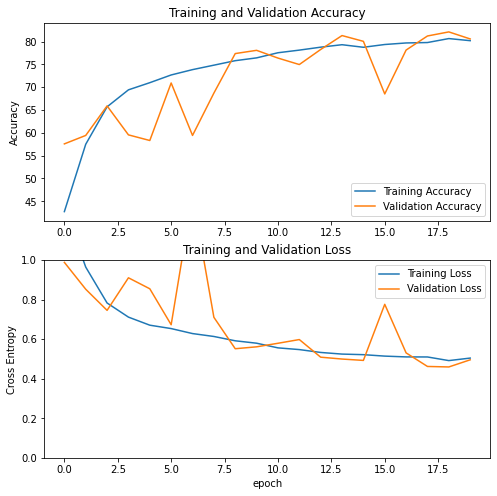

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()